In [1]:
!pip install pandas numpy matplotlib hyperopt scikit-learn xgboost seaborn
!pip install sdv nbformat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.2/145.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 91.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 87.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 3.11.0
    Uninstalling platformdirs-3.11.0:
      Successfully uninstalled platformdirs-3.11.0
  Attempting uninstall: plotly
    Found existing installation: plotly 5.18.0
    Uninst

In [2]:
import pandas as pd
import numpy as np
import time
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, STATUS_FAIL
import hyperopt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle
import os
import matplotlib.pyplot as plt
import random

import sdv

print(sdv.version.public)

1.14.0


binary

In [4]:
def process_alarms_bi(df):
    alarm_columns = [col for col in df.columns if col.startswith('alarm')]
    for col in alarm_columns:
        df[col] = df[col].apply(lambda x: 1 if x > 0 else 0)
    return df

df = pd.read_csv('/kaggle/input/halodwd/dataset_alarms_anonymized.csv')

df_processed = process_alarms_bi(df)

display(df)

,alarm_0,alarm_1,alarm_2,alarm_3,alarm_4,alarm_5,alarm_6,alarm_7,alarm_8,alarm_9,...,alarm_155,alarm_156,alarm_157,alarm_158,alarm_159,alarm_160,alarm_161,alarm_162,alarm_163,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1664,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,3
1665,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,3
1666,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1667,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


Categorical

In [6]:
def process_alarms_cat(df):
    alarm_columns = [col for col in df.columns if col.startswith('alarm')]
    for col in alarm_columns:
        df[col] = df[col].apply(lambda x: 1 if 0 < x <= 45 else (2 if 45 < x <= 450 else (3 if x > 450 else 0)))
    return df

df = pd.read_csv('/kaggle/input/halodwd/dataset_alarms_anonymized.csv')


df_processed_cat = process_alarms_cat(df)

display(df)

,alarm_0,alarm_1,alarm_2,alarm_3,alarm_4,alarm_5,alarm_6,alarm_7,alarm_8,alarm_9,...,alarm_155,alarm_156,alarm_157,alarm_158,alarm_159,alarm_160,alarm_161,alarm_162,alarm_163,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1664,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,3
1665,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,3
1666,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1667,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [7]:
X_bin, y_bin = df_processed.drop('label', axis=1).to_numpy(), df_processed['label'].to_numpy()
X_cat, y_cat = df_processed_cat.drop('label', axis=1).to_numpy(), df_processed_cat['label'].to_numpy()
print(X_bin.shape, y_bin.shape, X_cat.shape, y_cat.shape)

(1669, 164) (1669,) (1669, 164) (1669,)


## kNN Classifier Training

In [ ]:
INNER_CV = 5
NEIGHBORS = range(1, 10)

In [ ]:
def optimize_KNN(X_train, y_train, k=5):
#Inputs: - X_train: training set (features)
#        - y_train: training set (ground truth labels)
#        - data_gen_func: function that generates (possibly) synthetic data for training
#Output: - knn: model to be returned by the function
#        - best_cv_acc: best crossvalidation accuracy obtained with the best hyperparameters

    # Search space for KNN
    space4knn = {
     'neighb': hp.choice('neighb', NEIGHBORS),
     'wgts': hp.choice('wgts', ['uniform', 'distance']),
    }

    def hyperopt_train_test(params):
        accuracies = []
        kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
        for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
            X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

            # Generate synthetic data
            #X_train_cv, y_train_cv = data_gen_func(X_train_cv, y_train_cv)

            # Instantiate and fit model, calculate accuracy on cross-validation set
            model = KNeighborsClassifier(n_neighbors=params['neighb'], weights=params['wgts'])
            model.fit(X_train_cv, y_train_cv)
            acc = model.score(X_test_cv, y_test_cv)
            accuracies.append(acc)

        return sum(accuracies)/len(accuracies)

    def f(params): #F: this function is used below, as a parameter to fmin
        acc = hyperopt_train_test(params)
        return {'loss': -acc, 'status': STATUS_OK} #F: loss is returned as opposite (negative) of accuracy because we will use in f_min (that only minimizes), where we want to minimize the loss (i.e., maximize accuracy)

    trials = Trials() #F: an object that keeps track of all trials (i.e., combination of hyperparameters) tested during the optimization

    ta = time.time()
    best_params = fmin(f, space4knn, algo=tpe.suggest, max_evals=100, trials=trials)

    #F: at this point, best_param is a dictionary where each key is the index of the corresponding best param in space4rf
    tb = time.time()
    best_params = hyperopt.space_eval(space4knn, best_params)
    #F: this is used to extract from space4rf the best values
    #   according to the indexes in best_params (and put such values in best_params)

    best_cv_acc = -trials.best_trial['result']['loss'] #F: best across trials
    print('best_cv_acc: ' + str(best_cv_acc))
    print('Crossvalidation duration for KNN is {} s\n'.format(round(tb - ta)))

    
    #F: Now you have best hyperparameters obtained with crossvalidation and should train a new model
    #   using the entire training set using those hyperparameters and return the trained model
    knn = KNeighborsClassifier(n_neighbors=best_params['neighb'], weights=best_params['wgts'])

    t0 = time.time()
    knn.fit(X_train, y_train)
    t1 = time.time()

    print('Best number of neighbors: {}\n'.format(best_params['neighb']))
    print('Best weight function: {}\n'.format(best_params['wgts']))
    print('Crossvalidation accuracy: {}\n'.format(best_cv_acc))
    print('Training duration for KNN is {} s\n'.format(round(t1 - t0)))

    return knn, best_cv_acc

## Random forest classifier training

In [ ]:
def optimize_RF(X_train, y_train, k=5):
#Inputs: - X_train: training set (features)
#        - y_train: training set (ground truth labels)
#        - data_gen_func: function that generates (possibly) synthetic data for training
#Output: - rf: model to be returned by the function
#
#This function should:
#         * Perform RF hyperparameters optimization via crossvalidation
#         * Print best hyperparameters obtained with crossvalidation
#         * Print best crossvalidation accuracy (across all hyperparameters combinations) and duration
#         * Retrain a new RF model with best hyperparameters using the entire training set (X_train, y_train)
#         * Print training results (best accuracy and training duration)
#         * Return the trained RF model

    #F: define the search space for your hyperparameters
    space4rf = {
     'estimators': hp.choice('estimators', [10, 50, 100, 200, 500]),
     'crit': hp.choice('crit', ['gini', 'entropy', 'log_loss']),
     'maxd': hp.choice('maxd', np.arange(1, 20, 2)),
    }

    def hyperopt_train_test_rf(params):
        accuracies = []
        kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
        for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
            X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

            # Instantiate and fit model, calculate accuracy on cross-validation set
            model = RandomForestClassifier(n_estimators=params['estimators'], criterion=params['crit'],
                                       max_depth=params['maxd'], class_weight='balanced')
            model.fit(X_train_cv, y_train_cv)
            acc = model.score(X_test_cv, y_test_cv)
            accuracies.append(acc)

        return sum(accuracies)/len(accuracies)
    
    def f(params): #F: this function is used below, as a parameter to fmin
        acc = hyperopt_train_test_rf(params)
        return {'loss': -acc, 'status': STATUS_OK} #F: loss is returned as opposite (negative) of accuracy because we will use in f_min (that only minimizes), where we want to minimize the loss (i.e., maximize accuracy)

    trials = Trials() #F: an object that keeps track of all trials (i.e., combination of hyperparameters) tested during the optimization

    ta = time.time()
    best_params = fmin(f, space4rf, algo=tpe.suggest, max_evals=100, trials=trials)
    #F: see: https://github.com/hyperopt/hyperopt/blob/master/hyperopt/fmin.py
    #F: at this point, best_param is a dictionary where each key is the index of the corresponding best param in space4rf
    tb = time.time()
    print(best_params)

    best_params = hyperopt.space_eval(space4rf, best_params)
    #F: this is used to extract from space4rf the best values
    #   according to the indexes in best_params (and put such values in best_params)
    print(best_params)

    best_cv_acc = -round(trials.best_trial['result']['loss'], 2) #F: best across trials
    print('best_cv_acc: ' + str(best_cv_acc))
    print('Crossvalidation duration for RF is {} s\n'.format(round(tb - ta)))


    #######################################################################################################
    #F: Now you have best hyperparameters obtained with crossvalidation and should train a new model
    #   using those hyperparameters and the entire training set; then return the trained model

    rf = RandomForestClassifier(n_estimators=best_params['estimators'], criterion=best_params['crit'],
                                       max_depth=best_params['maxd'], class_weight='balanced')

    t0 = time.time()
    rf.fit(X_train, y_train)
    t1 = time.time()

    print('Best number of estimators: {}\n'.format(best_params['estimators']))
    print('Best splitting criterion: {}\n'.format(best_params['crit']))
    print('Best max_depth: {}\n'.format(best_params['maxd']))
    print('Crossvalidation accuracy: {}\n'.format(best_cv_acc))
    print('Training duration for RF is {} s\n'.format(round(t1 - t0)))

    # Plot accuracies for each hyperparameter combination
    for t in trials.trials:
        plt.scatter(t['tid'], -t['result']['loss'])
        plt.xticks(range(len(trials.trials)), range(len(trials.trials)))

    return rf, best_cv_acc


## XGBoost Classifier training

In [ ]:
from xgboost import XGBClassifier

def optimize_XGB(X_train, y_train, k=5):
#Inputs: - X_train: training set (features)
#        - y_train: training set (ground truth labels)
#        - data_gen_func: function that generates (possibly) synthetic data for training
#Output: - rf: model to be returned by the function
#
#This function should:
#         * Perform RF hyperparameters optimization via crossvalidation
#         * Print best hyperparameters obtained with crossvalidation
#         * Print best crossvalidation accuracy (across all hyperparameters combinations) and duration
#         * Retrain a new RF model with best hyperparameters using the entire training set (X_train, y_train)
#         * Print training results (best accuracy and training duration)
#         * Return the trained RF model

    #F: define the search space for your hyperparameters
    space4xgb = {
     'estimators': hp.choice('estimators', range(1, 20)),
     'max_depth': hp.choice('max_depth', range(1, 20)),
     'subsample': hp.choice('subsample', np.arange(0.1, 1, 0.01)),
    }

    def hyperopt_train_test_rf(params):
        accuracies = []
        kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
        for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
            X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

            # Instantiate and fit model, calculate accuracy on cross-validation set
            model = XGBClassifier(n_estimators=params['estimators'], max_depth=params['max_depth'], subsample=params['subsample'])
            model.fit(X_train_cv, y_train_cv)
            acc = model.score(X_test_cv, y_test_cv)
            accuracies.append(acc)

        return sum(accuracies)/len(accuracies)
    
    def f(params): #F: this function is used below, as a parameter to fmin
        acc = hyperopt_train_test_rf(params)
        return {'loss': -acc, 'status': STATUS_OK} #F: loss is returned as opposite (negative) of accuracy because we will use in f_min (that only minimizes), where we want to minimize the loss (i.e., maximize accuracy)

    trials = Trials() #F: an object that keeps track of all trials (i.e., combination of hyperparameters) tested during the optimization

    ta = time.time()
    best_params = fmin(f, space4xgb, algo=tpe.suggest, max_evals=20, trials=trials)
    #F: see: https://github.com/hyperopt/hyperopt/blob/master/hyperopt/fmin.py
    #F: at this point, best_param is a dictionary where each key is the index of the corresponding best param in space4rf
    tb = time.time()
    print(best_params)

    best_params = hyperopt.space_eval(space4xgb, best_params)
    #F: this is used to extract from space4rf the best values
    #   according to the indexes in best_params (and put such values in best_params)
    print(best_params)

    best_cv_acc = -round(trials.best_trial['result']['loss'], 2) #F: best across trials
    print('best_cv_acc: ' + str(best_cv_acc))
    print('Crossvalidation duration for RF is {} s\n'.format(round(tb - ta)))


    #######################################################################################################
    #F: Now you have best hyperparameters obtained with crossvalidation and should train a new model
    #   using those hyperparameters and the entire training set; then return the trained model

    final_xgb = XGBClassifier(n_estimators=best_params['estimators'], max_depth=best_params['max_depth'], subsample=best_params['subsample'])

    t0 = time.time()
    final_xgb.fit(X_train, y_train)
    t1 = time.time()

    print('Best number of estimators: {}\n'.format(best_params['estimators']))
    print('Best max depth: {}\n'.format(best_params['max_depth']))
    print('Best subsample rate: {}\n'.format(best_params['subsample']))
    print('Crossvalidation accuracy: {}\n'.format(best_cv_acc))
    print('Training duration for RF is {} s\n'.format(round(t1 - t0)))

    # Plot accuracies for each hyperparameter combination
    for t in trials.trials:
        plt.scatter(t['tid'], -t['result']['loss'])
        plt.xticks(range(len(trials.trials)), range(len(trials.trials)))

    return final_xgb, best_cv_acc


## Multi-layer-perceptron training

In [ ]:
from sklearn.neural_network import MLPClassifier
import warnings

def optimize_MLP(X_train, y_train, k=5):
    # Inputs: - X_train: training set (features)
    #         - y_train: training set (ground truth labels)
    #         - data_gen_func: function that generates (possibly) synthetic data for training
    # Output: - mlp: model to be returned by the function

    # Define the search space for your hyperparameters
    space4mlp = {
        'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [(50,), (100,), (50, 50), (100, 100)]),
        'activation': hp.choice('activation', ['identity', 'logistic', 'tanh', 'relu']),
        'solver': hp.choice('solver', ['lbfgs', 'sgd', 'adam']),
        'alpha': hp.loguniform('alpha', -4, 0),  # equivalent to 10**uniform(-4, 0)
        'learning_rate': hp.choice('learning_rate', ['constant', 'invscaling', 'adaptive']),
        #'max_iter': hp.choice('max_iter', [200, 400, 800, 1600])
    }

    def hyperopt_train_test_mlp(params):
        print(params)

        accuracies = []
        kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
        for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
            X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

            # Instantiate and fit model, calculate accuracy on cross-validation set
            with warnings.catch_warnings(record=True) as w:
                warnings.simplefilter("always")
                model = MLPClassifier(hidden_layer_sizes=params['hidden_layer_sizes'], activation=params['activation'],
                                    solver=params['solver'], alpha=params['alpha'],
                                    learning_rate=params['learning_rate'], max_iter=5000)
                model.fit(X_train_cv, y_train_cv)
                acc = model.score(X_test_cv, y_test_cv)
                accuracies.append(acc)

                # Check for warnings
                if len(w) > 0:
                    for warning in w:
                        print(str(warning.message))

        return sum(accuracies) / len(accuracies), len(w) == 0   # True if no warnings

    def f(params):  # This function is used below, as a parameter to fmin
        acc, status = hyperopt_train_test_mlp(params)
        return {'loss': -acc, 'status': STATUS_OK if status else STATUS_FAIL} # Status is OK if no warnings
    trials = Trials()

    ta = time.time()
    best_params = fmin(f, space4mlp, algo=tpe.suggest, max_evals=20, trials=trials)
    tb = time.time()
    print(best_params)

    best_params = hyperopt.space_eval(space4mlp, best_params)
    print(best_params)

    best_cv_acc = -round(trials.best_trial['result']['loss'], 2)  # best across trials
    print('best_cv_acc: ' + str(best_cv_acc))
    print('Crossvalidation duration for MLP is {} s\n'.format(round(tb - ta)))

    mlp = MLPClassifier(hidden_layer_sizes=best_params['hidden_layer_sizes'], activation=best_params['activation'],
                        solver=best_params['solver'], alpha=best_params['alpha'],
                        learning_rate=best_params['learning_rate'], max_iter=2000)

    t0 = time.time()
    mlp.fit(X_train, y_train)
    t1 = time.time()

    print('Best hidden_layer_sizes: {}\n'.format(best_params['hidden_layer_sizes']))
    print('Best activation function: {}\n'.format(best_params['activation']))
    print('Best solver: {}\n'.format(best_params['solver']))
    print('Best alpha: {}\n'.format(best_params['alpha']))
    print('Best learning rate: {}\n'.format(best_params['learning_rate']))
    #print('Best max_iter: {}\n'.format(best_params['max_iter']))
    print('Crossvalidation accuracy: {}\n'.format(best_cv_acc))
    print('Training duration for MLP is {} s\n'.format(round(t1 - t0)))

    # Plot accuracies for each hyperparameter combination
    for t in trials.trials:
        plt.scatter(t['tid'], -t['result']['loss'])
        plt.xticks(range(len(trials.trials)), range(len(trials.trials)))

    return mlp, best_cv_acc


## SVM

In [ ]:
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL

def optimize_SVM(X_train, y_train, k=5):
    # Define the search space for hyperparameters
    space4svm = {
        'C': hp.loguniform('C', -12, 6),  # equivalent to 10**uniform(-4, 2)
        'gamma': hp.loguniform('gamma', -8, 5)  # equivalent to 10**uniform(-4, 1)
    }

    def hyperopt_train_test_svm(params):
        accuracies = []
        kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
        for train_index, test_index in kf.split(X_train, y_train):
            X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

            # Instantiate and fit model, calculate accuracy on cross-validation set
            with warnings.catch_warnings(record=True) as w:
                warnings.simplefilter("always")
                model = SVC(C=params['C'], gamma=params['gamma'], kernel='sigmoid')
                model.fit(X_train_cv, y_train_cv)
                acc = model.score(X_test_cv, y_test_cv)
                accuracies.append(acc)

                # Check for warnings
                if len(w) > 0:
                    for warning in w:
                        print(str(warning.message))

        return sum(accuracies) / len(accuracies), len(w) == 0  # True if no warnings

    def f(params):  # This function is used below, as a parameter to fmin
        acc, status = hyperopt_train_test_svm(params)
        return {'loss': -acc, 'status': STATUS_OK if status else STATUS_FAIL}  # Status is OK if no warnings

    trials = Trials()
    ta = time.time()
    best_params = fmin(f, space4svm, algo=tpe.suggest, max_evals=50, trials=trials)
    tb = time.time()
    print(best_params)

    best_params = hyperopt.space_eval(space4svm, best_params)
    print(best_params)

    best_cv_acc = -round(trials.best_trial['result']['loss'], 2)  # best across trials
    print('best_cv_acc: ' + str(best_cv_acc))
    print('Crossvalidation duration for SVM is {} s\n'.format(round(tb - ta)))

    svm = SVC(C=best_params['C'], gamma=best_params['gamma'], kernel='rbf')

    t0 = time.time()
    svm.fit(X_train, y_train)
    t1 = time.time()

    print('Best C: {}\n'.format(best_params['C']))
    print('Best gamma: {}\n'.format(best_params['gamma']))
    print('Crossvalidation accuracy: {}\n'.format(best_cv_acc))
    print('Training duration for SVM is {} s\n'.format(round(t1 - t0)))

    # Plot accuracies for each hyperparameter combination
    plt.figure(figsize=(10, 6))
    for t in trials.trials:
        plt.scatter(t['tid'], -t['result']['loss'], label=f"Trial {t['tid']}")
    plt.xlabel("Trial")
    plt.ylabel("Accuracy")
    plt.title("Hyperopt Trials")
    plt.legend()
    plt.show()

    return svm, best_cv_acc


## Visualization of the data

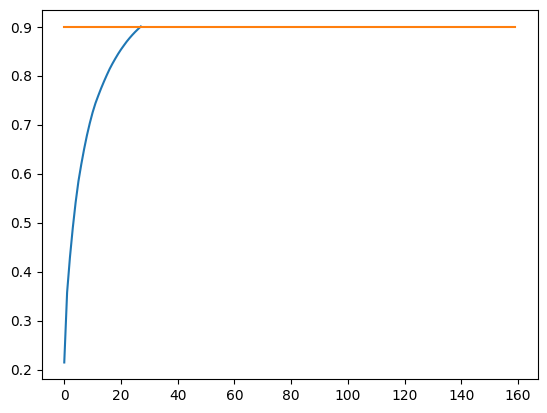

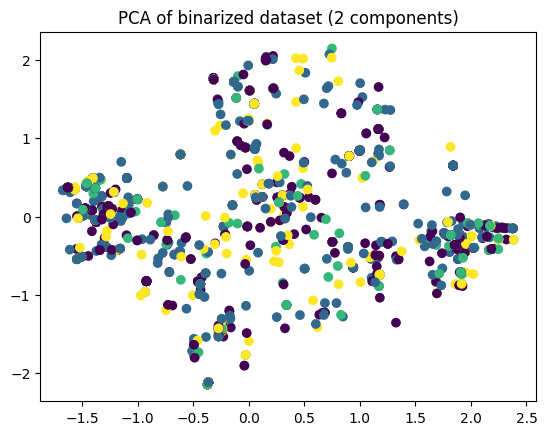

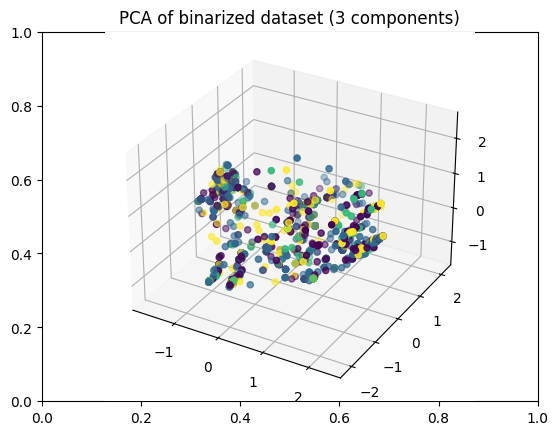

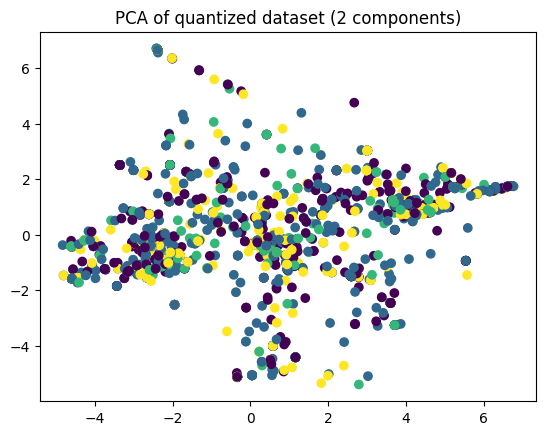

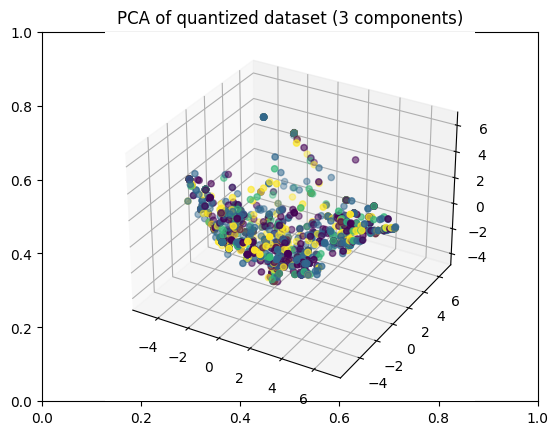

In [8]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components=0.9)
X_bin_pca = pca_model.fit_transform(X_bin)
X_bin_pca.shape
plt.plot(np.cumsum(pca_model.explained_variance_ratio_))
plt.plot([0.9]*160)

# Visualize the first two components
plt.figure()
plt.title('PCA of binarized dataset (2 components)')
plt.scatter(X_bin_pca[:, 0], X_bin_pca[:, 1], c=y_bin)

# Visualize the first three components
from mpl_toolkits.mplot3d import Axes3D
plt.figure()
plt.title('PCA of binarized dataset (3 components)')
ax = plt.axes(projection='3d')
ax.scatter(X_bin_pca[:, 0], X_bin_pca[:, 1], X_bin_pca[:, 2], c=y_bin)

# Quantized dataset
pca_model = PCA(n_components=0.9)
X_cat_pca = pca_model.fit_transform(X_cat)

# Visualize the first two components
plt.figure()
plt.title('PCA of quantized dataset (2 components)')
plt.scatter(X_cat_pca[:, 0], X_cat_pca[:, 1], c=y_cat)

# Visualize the first three components
from mpl_toolkits.mplot3d import Axes3D
plt.figure()
plt.title('PCA of quantized dataset (3 components)')
ax = plt.axes(projection='3d')
ax.scatter(X_cat_pca[:, 0], X_cat_pca[:, 1], X_cat_pca[:, 2], c=y_cat);

### t-SNE

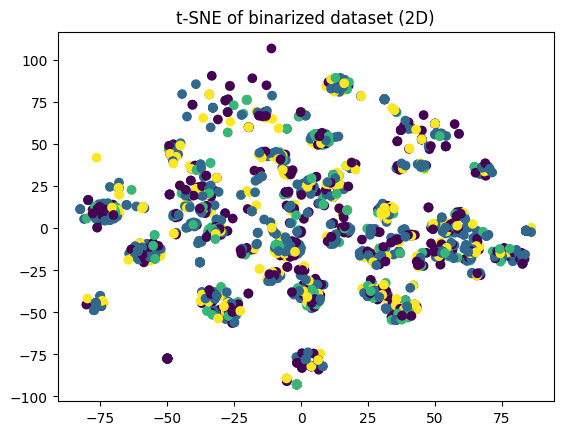

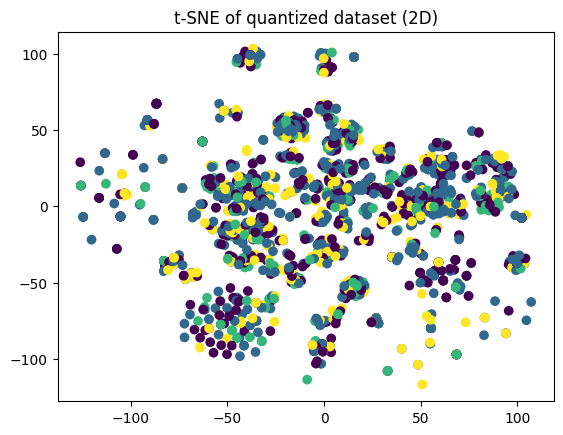

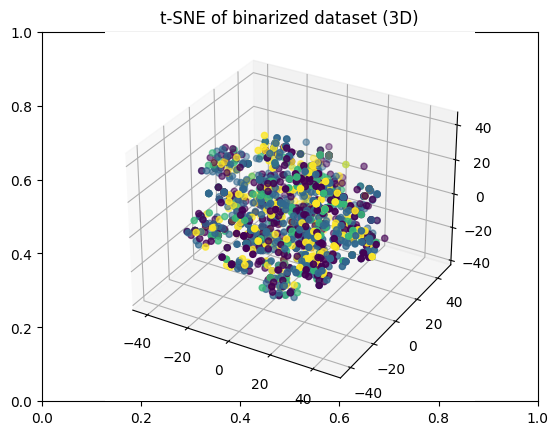

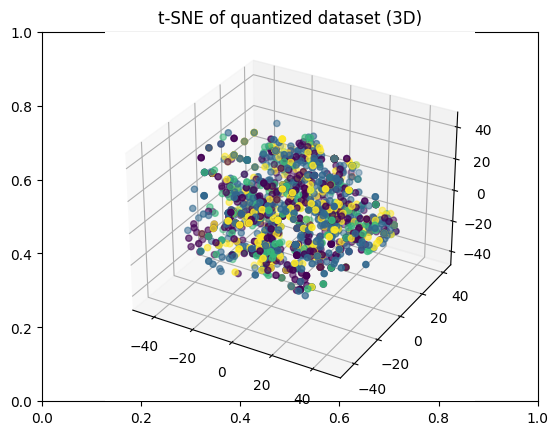

In [9]:
# t-SNE and visualization
from sklearn.manifold import TSNE

# first, let's reduce the dimensionality of the datasets for t-SNE to work properly using TruncatedSVD (since data is sparse)
from sklearn.decomposition import TruncatedSVD

svd_model_bin = TruncatedSVD(n_components=50)
X_bin_svd = svd_model_bin.fit_transform(X_bin)
svd_model_cat = TruncatedSVD(n_components=50)
X_cat_svd = svd_model_cat.fit_transform(X_cat)

# 2D t-SNE
tsne_model_bin_2d = TSNE(n_components=2, perplexity=30, n_iter=1000)
X_bin_tsne_2d = tsne_model_bin_2d.fit_transform(X_bin_svd)

tsne_model_cat_2d = TSNE(n_components=2, perplexity=30, n_iter=1000)
X_cat_tsne_2d = tsne_model_cat_2d.fit_transform(X_cat_svd)

plt.figure()
plt.title('t-SNE of binarized dataset (2D)')
plt.scatter(X_bin_tsne_2d[:, 0], X_bin_tsne_2d[:, 1], c=y_bin)

plt.figure()
plt.title('t-SNE of quantized dataset (2D)')
plt.scatter(X_cat_tsne_2d[:, 0], X_cat_tsne_2d[:, 1], c=y_cat)

# 3D t-SNE
tsne_model_bin_3d = TSNE(n_components=3, perplexity=30, n_iter=1000)
X_bin_tsne_3d = tsne_model_bin_3d.fit_transform(X_bin_svd)

tsne_model_cat_3d = TSNE(n_components=3, perplexity=30, n_iter=1000)
X_cat_tsne_3d = tsne_model_cat_3d.fit_transform(X_cat_svd)

from mpl_toolkits.mplot3d import Axes3D
plt.figure()
plt.title('t-SNE of binarized dataset (3D)')
ax = plt.axes(projection='3d')
ax.scatter(X_bin_tsne_3d[:, 0], X_bin_tsne_3d[:, 1], X_bin_tsne_3d[:, 2], c=y_bin)

plt.figure()
plt.title('t-SNE of quantized dataset (3D)')
ax = plt.axes(projection='3d')
ax.scatter(X_cat_tsne_3d[:, 0], X_cat_tsne_3d[:, 1], X_cat_tsne_3d[:, 2], c=y_cat);


In [1]:
#Remove X% of the data points of class Y from the training set
#used for DataGen-2
#class_label:0/1/2/3
def remove_class_percentage(data, class_label, percentage, label_column='label'):
    X = data.drop(columns=label_column)
    y = data[label_column]
    print(f"label distribution before remove points: {Counter(y)}")

    class_data = data[data[label_column] == class_label]
    # find the number of the data needed to be deleted
    num_to_remove = int(len(class_data) * (percentage / 100))

    indices_to_remove = np.random.choice(class_data.index, size=num_to_remove, replace=False)

    data_remaining = data.drop(indices_to_remove)
    X = data_remaining.drop(columns=label_column)
    y = data_remaining[label_column]
    print(f"label distribution after remove points: {Counter(y)}")

    return data_remaining

result_data = remove_class_percentage(df_processed, class_label=2, percentage=80)


NameError: name 'df_processed' is not defined

## SMOTE


In [ ]:
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
#Add a fixed number of datapoints per class WITH SMOTE (e.g., add 300 data points per each class)
#used for DataGen-2.2
#n_samples:the number points we want to add
def add_datapoints_SMOTE(data, label_column='label', n_samples=300, random_state=42):

    print(f"label distribution before adding points: {Counter(data[label_column])}")

    new_data = []

    # get all the classes
    classes = data[label_column].unique()

    for class_label in classes:
        class_data = data[data[label_column] == class_label]
        other_data = data[data[label_column] != class_label]
        X = class_data.drop(columns=label_column)
        y = class_data[label_column]

        X_smote = pd.concat([X, other_data.drop(columns=label_column)])
        y_smote = pd.concat([y, other_data[label_column]])

        # add points
        smote = SMOTE(sampling_strategy={class_label: len(class_data) + n_samples}, random_state=random_state)
        X_resampled, y_resampled = smote.fit_resample(X_smote, y_smote)

        # filter the new datas:
        new_class_data = X_resampled[y_resampled == class_label].iloc[len(class_data):]
        new_class_labels = y_resampled[y_resampled == class_label].iloc[len(class_data):]

        # add the new data into the old one
        resampled_data = pd.concat([pd.DataFrame(new_class_data, columns=X.columns), pd.DataFrame(new_class_labels, columns=[label_column])], axis=1)
        new_data.append(resampled_data)

    if new_data:
        new_data = pd.concat(new_data, axis=0)
        result_data = pd.concat([data, new_data], axis=0).reset_index(drop=True)


    print(f"label distribution after adding points: {Counter(result_data[label_column])}")

    return result_data

In [ ]:
#used for DataGen-1,DataGen-2.1
#input:the data needed to be rebalance
def balance_smote(X, y, label_column='label', random_state=42):
    print(f"label distribution before: {Counter(y)}")

    smote = SMOTE(random_state=random_state)

    # use smote
    X_resampled, y_resampled = smote.fit_resample(X, y)

    print(f"label distribution after: {Counter(y_resampled)}")

    # make it into a dataframe as output
    #df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=[label_column])], axis=1)

    return X_resampled, y_resampled

## GAN

In [ ]:
def get_X_y(df):
    X = df.drop('label', axis=1).to_numpy()
    y = df['label'].to_numpy()
    return X, y

In [ ]:
def concat_datasets(X1, y1, X2, y2):
    return np.concatenate((X1, X2), axis=0), np.concatenate((y1, y2), axis=0)

In [ ]:
def create_df(X, y):
    df = pd.DataFrame()
    for i in range(X.shape[1]):
        df[f'alarm_{i}'] = X[:, i]
    df['label'] = y
    return df

In [ ]:
import pandas as pd
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
from sdv.sampling import Condition
from typing import Optional


def balance_gan(
    data,
    label_column="label",
    random_state=42,
    fixed_number_of_samples: Optional[int] = None,
):
    # Split data by class
    data = data.sample(frac=1, random_state=random_state).reset_index(drop=True)
    class_data = data.groupby(label_column)
    for cls, subset in class_data:
        print(f"Class {cls} has {len(subset)} samples")

    # Determine target class size (size of the largest class)
    if not fixed_number_of_samples:
        target_size = class_data.size().max()
        print(f"Majority class size: {target_size}")

    # Generate synthetic data for minority classes
    synthetic_data = pd.DataFrame()
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data)

    # Initialize and fit the CTGANSynthesizer
    ctgan = CTGANSynthesizer(metadata=metadata, epochs=600)
    ctgan.fit(data)

    # Calculate the number of samples needed for each class
    if fixed_number_of_samples:
        samples_needed = {cls: fixed_number_of_samples for cls, _ in class_data}
    else:
        samples_needed = {cls: target_size - len(subset) for cls, subset in class_data}
        print(f"Samples needed to evenly balance: {samples_needed}")

    # Generate conditions for each class to do conditional sampling
    conditions = [
        Condition(column_values={label_column: cls}, num_rows=samples_needed[cls])
        for cls in samples_needed
    ]

    # Sample synthetic data for each class
    synthetic_data = ctgan.sample_from_conditions(conditions=conditions)
    
    # Combine original and synthetic data
    balanced_data = pd.concat([data, synthetic_data], ignore_index=True)

    return ctgan, balanced_data, synthetic_data, metadata

In [ ]:
#ctgan, evenly_balanced_dataset, evenly_synthentic_data, evenly_metadata = balance_gan(
#    df_processed
#)
#ctgan2, fixed_add_dataset, fixed_synthetic_data, fix_metadata = balance_gan(
#    df_processed, fixed_number_of_samples=300
#)

In [ ]:
#evenly_balanced_dataset

In [ ]:
# save models
#ctgan.save('ctgan_evenly_balanced.pkl')
#ctgan2.save('ctgan_fixed_balanced.pkl')

In [ ]:
# reload models
#ctgan = CTGANSynthesizer.load('ctgan_evenly_balanced.pkl')
#ctgan2 = CTGANSynthesizer.load('ctgan_fixed_balanced.pkl')

## Cross-validation and testing with data generation

In [ ]:
from typing import Optional
from sklearn.metrics import confusion_matrix
import seaborn as sns


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def train_and_test_model(
    X, y, 
    k_test=5, 
    k_valid=5, 
    model='KNN', 
    data_gen_algorithm=None, 
    fixed_n_samples=None,
    data_version=None
):
    # Test set, used for averaging performance
    outer_kf = StratifiedKFold(n_splits=k_test, random_state=42, shuffle=True)
    accuracies = []
    for i, (train_index, test_index) in enumerate(outer_kf.split(X, y)):

        # Split data into (training + validation) and test set
        X_tmp, X_test = X[train_index], X[test_index]
        y_tmp, y_test = y[train_index], y[test_index]

        # Handle data generation based on the specified algorithm and data version
        if data_gen_algorithm == 'GAN':
            if fixed_n_samples is None:
                X_tmp, y_tmp = get_X_y(balance_gan(create_df(X_tmp, y_tmp), label_column='label')[1])
                display(create_df(X_tmp, y_tmp))
            else:
                result_data = remove_class_percentage(create_df(X_tmp, y_tmp), class_label=2, percentage=80)
                if data_version == '2.1':
                    X_tmp, y_tmp = get_X_y(balance_gan(result_data, label_column='label', random_state=42, fixed_number_of_samples=fixed_n_samples)[1])
                elif data_version == '2.2':
                    X_tmp, y_tmp = get_X_y(balance_gan(result_data, label_column='label', random_state=42)[1])
                display(create_df(X_tmp, y_tmp))
        elif data_gen_algorithm == 'SMOTE':
            if fixed_n_samples is None:
                X_tmp, y_tmp = balance_smote(X_tmp, y_tmp)
                display(create_df(X_tmp, y_tmp))
            else:
                result_data = remove_class_percentage(create_df(X_tmp, y_tmp), class_label=2, percentage=80)
                if data_version == '2.1':
                    result_data = add_datapoints_SMOTE(result_data, label_column='label', n_samples=fixed_n_samples, random_state=42)
                    X_tmp, y_tmp = get_X_y(result_data)
                elif data_version == '2.2':
                    X_tmp, y_tmp = balance_smote(get_X_y(result_data))
                display(create_df(X_tmp, y_tmp))

        # Cross-validate model, using i-th fold
        if model == 'KNN':
            best_model, _ = optimize_KNN(X_tmp, y_tmp, k=k_valid)
        elif model == 'RF':
            best_model, _ = optimize_RF(X_tmp, y_tmp, k=k_valid)
        elif model == 'XGB':
            best_model, _ = optimize_XGB(X_tmp, y_tmp, k=k_valid)
        elif model == 'MLP':
            best_model, _ = optimize_MLP(X_tmp, y_tmp, k=k_valid)
        elif model == 'SVM':
            best_model, _ = optimize_SVM(X_tmp, y_tmp, k=k_valid)
        else:
            return None

        # Accuracy on test set
        y_test_pred = best_model.predict(X_test)
        test_set_accuracy = np.mean(y_test_pred == y_test)
        accuracies.append(test_set_accuracy)
        print(f'{i+1}th fold test set accuracy: {test_set_accuracy}')

        # Display confusion matrix
        cm = confusion_matrix(y_test, y_test_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    return sum(accuracies) / len(accuracies)


In [ ]:
acc = train_and_test_model(X=X_bin, y=y_bin, k_test=5, k_valid=5, model='KNN', data_gen_algorithm='SMOTE'，fixed_n_samples=1000， data_version=2.1)